## Libraries and helper function

In [1]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap


import warnings
warnings.filterwarnings("ignore")

features_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ] 

features_bvp_names = None

The `extract_sc` and `extract_bvp` are the function to extract the physio features with the `neurokit` library
The library provides several ways to extract different types of physio features, the function that we are using is:
1. `eda_process()` for skin conductance (SC)
2. `ppg_process()` for blood volume pressure (BVP)

In [2]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])
    
    return features_sc

def extract_bvp(signal):
    global features_bvp_names
    df, info = nk.ppg_process(signal, sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    if features_bvp_names == None:
        features_bvp_names = list(feature_bvp)
        
    feature_bvp = feature_bvp[features_bvp_names]
        
    return feature_bvp.to_numpy()[0]

The `extract_all_data()` is a function that is used to extract all the data from the dataset.
It has the `data_dict` being passed to add all the features into the dictionary.
`with_keystroke` is a optional parameter in order to include (True) or exclude (False) the keystrokes as the data.
`effect` is a a parameter to set which class to extract from the `class` in the dataset.

In [3]:
def extract_all_data(data_dict, with_keystroke=False, effect='challenge'):
    for a in tqdm(range(36)): # player number
        player_demographics = p_demo[a] # player demographics
        player_game = p_games[a]
        player_tutorial = p_tutorial[a]
        
        for b in range(len(player_game)): # game number
            game_pref = p_games[a][b]['preferences']
            game_a = p_games[a][b]['data']['A'][0]
            game_b = p_games[a][b]['data']['B']
            game_keystroke_a = p_games[a][b]['data']['A'][0]['keystrokes']
            game_keystroke_b = p_games[a][b]['data']['B']['keystrokes']
            
            features_sc_a = extract_sc(game_a['physio']['SC'])
            features_bvp_a = extract_bvp(game_a['physio']['BVP'])
            
            features_sc_b = extract_sc(game_b['physio']['SC'])
            features_bvp_b = extract_bvp(game_b['physio']['BVP'])
            
            # append information for Game A
            data_dict['player_id'] += [player_demographics['player_id']]
            data_dict['player_age'] += [player_demographics['age']]
            data_dict['player_gender'] += [player_demographics['male']]
            data_dict['player_playgames'] += [player_demographics['playgames']]
            data_dict['player_playfrequency'] += [player_demographics['playgamesfrequency']]
            
            data_dict['game_variant'] += [game_a['variant']]
            data_dict['gameplay_score'] += [game_a['gameplay']['score'][-1]] # the last element in score array is the final score
            
            data_dict['features_sc'] += [features_sc_a]
            data_dict['features_bvp'] += [features_bvp_a]
            # calculate keystrokes per second and append information into alldata
            if with_keystroke:
                num_keystroke_a = 0
                for i in game_keystroke_a:
                    if i == "time":
                        break
                    num_keystroke_a += sum(game_keystroke_a[i])
                kps_a = num_keystroke_a / game_keystroke_a['time'][-1]
                data_dict['keystrokes'] += [kps_a]
                data_dict['keystrokes_mean'] += [np.mean(game_keystroke_a['time'])]
                data_dict['keystrokes_std'] += [np.std(game_keystroke_a['time'])]
                data_dict['keystrokes_min'] += [np.min(game_keystroke_a['time'])]
                data_dict['keystrokes_max'] += [np.max(game_keystroke_a['time'])]

            # append information for Game B
            data_dict['player_id'] += [player_demographics['player_id']]
            data_dict['player_age'] += [player_demographics['age']]
            data_dict['player_gender'] += [player_demographics['male']]
            data_dict['player_playgames'] += [player_demographics['playgames']]
            data_dict['player_playfrequency'] += [player_demographics['playgamesfrequency']]
            
            data_dict['game_variant'] += [game_b['variant']]
            data_dict['gameplay_score'] += [game_b['gameplay']['score'][-1]] # the last element in score array is the final score
            
            data_dict['features_sc'] += [features_sc_b]
            data_dict['features_bvp'] += [features_bvp_b]
            
            # calculate keystrokes per second and append information into alldata
            if with_keystroke:
                num_keystroke_b = 0
                for i in game_keystroke_b:
                    if i == "time":
                        break
                    num_keystroke_b += sum(game_keystroke_b[i])
                kps_b = num_keystroke_b / game_keystroke_b['time'][-1]
                data_dict['keystrokes'] += [kps_b]
                data_dict['keystrokes_mean'] += [np.mean(game_keystroke_b['time'])]
                data_dict['keystrokes_std'] += [np.std(game_keystroke_b['time'])]
                data_dict['keystrokes_min'] += [np.min(game_keystroke_b['time'])]
                data_dict['keystrokes_max'] += [np.max(game_keystroke_b['time'])]
                
            if isinstance(effect, str):
                temp = 'class_' + effect 
                
                if temp not in data_dict:
                    data_dict[temp] = []
                
                if game_pref[effect] == "A": # if game A is more intense than game B
                    data_dict[temp] += [1] # class label for Game A
                    data_dict[temp] += [0] # class label for Game B

                elif game_pref[effect] == "B": # if game B is more intense
                    data_dict[temp] += [0]
                    data_dict[temp] += [1]

                elif game_pref[effect] == "Both equally":
                    data_dict[temp] += [1]
                    data_dict[temp] += [1]

                elif game_pref[effect] == "Neither":
                    data_dict[temp] += [0]
                    data_dict[temp] += [0]
                    
            elif isinstance(effect, list):
                for label in effect:
                    temp = 'class_' + label
                    
                    if temp not in data_dict:
                        data_dict[temp] = []
                    
                    if game_pref[label] == "A": # if game A is more intense than game B
                        data_dict[temp] += [1] # class label for Game A
                        data_dict[temp] += [0] # class label for Game B

                    elif game_pref[label] == "B": # if game B is more intense
                        data_dict[temp] += [0]
                        data_dict[temp] += [1]

                    elif game_pref[label] == "Both equally":
                        data_dict[temp] += [1]
                        data_dict[temp] += [1]

                    elif game_pref[label] == "Neither":
                        data_dict[temp] += [0]
                        data_dict[temp] += [0]

## Data Preprocessing
In this part, we will process the dataset by reading and loading it into the `pandas.DataFrame()`.
Then we will extract all the features and classes we want to train the model.

In [4]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']

The following is the dictionary to save all the data that we need.

In [5]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],
    
    # games
    'game_variant': [],
    'gameplay_score': [], 
    'keystrokes': [], # keystrokes per second
    'keystrokes_mean': [],
    'keystrokes_std': [],
    'keystrokes_min': [], 
    'keystrokes_max': [],
    
    'features_sc': [],
    'features_bvp': [],

}

We can choose what are the labels that we want to predict, in this case I had done a wrapper function that can pass either a `String` or a `List` in order to update the dictionary to have all the labels that we want with the name (`class_relaxation, class_fun` etc.) 


For our case, we are choosing `relaxation` and `fun` for 

In [6]:
extract_all_data(data_dict = alldata, effect = ['relaxation', 'fun'], with_keystroke=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:48<00:00,  1.33s/it]


## Preparation for training

The first preparation is to load all the data into `X` which will become the input for the model. 
For first `X`, we will called it `X_physio` as it only has the physio feature in it.

The features included:
1. player_age
2. gender
3. player_playgames
4. player_playfrequency
5. game_variant
6. SC (Skin Inductance)
7. BVP (Blood Pressure Pulse)

In [7]:
# create dataset
X_physio = [] # training data
Z = []

In [8]:
for i in range(len(alldata['class_relaxation'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i],
                  alldata['gameplay_score'][i],
                  ]), 
            alldata['features_sc'][i],
            alldata['features_bvp'][i]
    ])
    X_physio += [vec.astype(float)]
    Z += [alldata['player_id'][i]]
    
feature_names_physio = ['player_age', 'player_gender', 'player_playgames', 'player_playfrequency', 'game_variant', 'gameplay_score']
feature_names_physio += features_sc_names
feature_names_physio += features_bvp_names

X_physio = np.array(X_physio)

print(X_physio.shape)

(288, 95)


The second preparation will include the physio and the keystroke of the player. Thus the list of feature will include:
1. player_age
2. gender
3. player_playgames
4. player_playfrequency
5. game_variant
6. SC (Skin Inductance)
7. BVP (Blood Pressure Pulse)
8. Keystrokes
9. keystrokes_mean
10. keystrokes_std
11. keystrokes_min
12. keystrokes_max

In [9]:
# create dataset
X_all = [] # training data

In [10]:
for i in range(len(alldata['class_relaxation'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i],
                  alldata['gameplay_score'][i],
                  alldata['keystrokes'][i],
                  alldata['keystrokes_mean'][i],
                  alldata['keystrokes_std'][i],
                  alldata['keystrokes_min'][i],
                  alldata['keystrokes_max'][i]]),
            alldata['features_sc'][i],
            alldata['features_bvp'][i]
    ])
    X_all += [vec.astype(float)]
    
feature_names_all = ['player_age', 'player_gender', 'player_playgames', 'player_playfrequency', 'game_variant', 'gameplay_score', 'keystrokes', 'keystrokes_mean', 'keystrokes_std', 'keystrokes_min', 'keystrokes_max']
feature_names_all += features_sc_names
feature_names_all += features_bvp_names

X_all = np.array(X_all)

print(X_all.shape)

(288, 100)


In [11]:
Y_relax = []
Y_fun = []
for i in range(len(alldata['class_relaxation'])):
    Y_relax += [alldata['class_relaxation'][i]]
    Y_fun += [alldata['class_fun'][i]]

Y_relax = np.array(Y_relax)
Y_fun = np.array(Y_fun)
Z = np.array(Z)
player_id = np.unique(Z)

We had then prepared two sets of different number feature for the model which is the `X_physio` and `X_all`. 

The physio training has 95 features and the all training set has 100 features.

The only difference is that the all training set has the keystrokes being extracted and being fitted to the model. 

We will then see how will the model perform after adding more features to the model.

Before fitting to the model, the `neurokit` library had return `inf` or `Nan`, so we will need to check whether there are these problems. We will set positive_inf and negative_inf to 0 and Nan to 0 also.

In [12]:
X_physio = np.nan_to_num(X_physio, neginf=0, posinf=0)
print(np.any(np.isnan(X_physio)))

False


In [13]:
X_all = np.nan_to_num(X_all, neginf=0, posinf=0)
print(np.any(np.isnan(X_all)))

False


In [14]:
alldata.keys()

dict_keys(['player_id', 'player_age', 'player_gender', 'player_playgames', 'player_playfrequency', 'game_variant', 'gameplay_score', 'keystrokes', 'keystrokes_mean', 'keystrokes_std', 'keystrokes_min', 'keystrokes_max', 'features_sc', 'features_bvp', 'class_relaxation', 'class_fun'])

## Model Training

For the model training we are using `AdaBoostClassifier` and `LightGradientBoostingMethod`.

Both of these models are Gradient-boosting models but with different approaches to it. 

The code below is being used for easy training with the two training sets that we have. 

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier 

In [16]:
def training_model(X, Y, Z, params, model='ada'):
    predictions = []
    labels = []
    
    for idx in tqdm(player_id):
        istrain = Z!=idx
        istest = Z==idx

        X_train = X[istrain]
        X_test = X[istest]
        Y_train = Y[istrain]
        Y_test = Y[istest]

        X_train = np.where(np.isnan(X_train), 0, X_train)
        X_test = np.where(np.isnan(X_test), 0, X_test)

        # Create an AdaBoost classifier with a decision tree as the base learner
        if model == 'ada':
            adaboost_clf = AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=1),
                **params
            )

            # Train the model
            adaboost_clf.fit(X_train, Y_train)

            # test the model
            Y_pred = adaboost_clf.predict(X_test)
            
            
        elif model == 'lgbm':
            lgb_eval = (X_test, Y_test)
            lgbm = LGBMClassifier(**params)
            
            lgbm.fit(X_train, Y_train, eval_set=lgb_eval) 
            Y_pred = lgbm.predict(X_test)

        # print('Y logits:', Y_pred)
        pred_class = (Y_pred > 0.5).astype("int")

        # print('Y predictions:', pred_class)

        predictions += [pred_class]
        labels += [Y_test]
        
        
    return (predictions, labels) if model == 'ada' else (lgbm, predictions, labels)

### Ada Boost Classifier
Below will show the result for training the `AdaBoostClassifier` and the visualization of the result.

In [17]:
'''
Below are the 
hyperparameter being used for the AdaBoost. 
'''

params_ada = {
    "n_estimators": 50,
    "learning_rate": 0.05,
    "algorithm": "SAMME.R",
    "random_state": 42,
}

#### AdaBoostClassifier with X_physio predicting 'relaxation' and 'fun'

In [18]:
predictions_physio_ada_relax, labels_physio_ada_relax = training_model(X_physio, Y_relax, Z, params_ada, model='ada')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.93it/s]


In [19]:
accuracy_physio_ada_relax = np.mean(np.concatenate(predictions_physio_ada_relax) == np.concatenate(labels_physio_ada_relax))
print(accuracy_physio_ada_relax)

0.6319444444444444


In [20]:
predictions_physio_ada_fun, labels_physio_ada_fun = training_model(X_physio, Y_fun, Z, params_ada, model='ada')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.93it/s]


In [21]:
accuracy_physio_ada_fun = np.mean(np.concatenate(predictions_physio_ada_fun) == np.concatenate(labels_physio_ada_fun))
print(accuracy_physio_ada_fun)

0.6458333333333334


#### AdaBoostClassifier with X_all predicting 'relaxation' and 'fun'

In [22]:
predictions_all_ada_relax, labels_all_ada_relax = training_model(X_all, Y_relax, Z, params_ada, model='ada')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.77it/s]


In [23]:
accuracy_all_ada_relax = np.mean(np.concatenate(predictions_all_ada_relax) == np.concatenate(labels_all_ada_relax))
print(accuracy_all_ada_relax)

0.6354166666666666


In [24]:
predictions_all_ada_fun, labels_all_ada_fun = training_model(X_all, Y_fun, Z, params_ada, model='ada')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.79it/s]


In [25]:
accuracy_all_ada_fun = np.mean(np.concatenate(predictions_all_ada_fun) == np.concatenate(labels_all_ada_fun))
print(accuracy_all_ada_fun)

0.6458333333333334


### Explanable with AdaBoostClassifier for 'relax'

In order to explain the result from `AdaBoostClassifier`, we can sample 100 entries from the training sets and use the `shap.KernelExplainer()` to explain the models.

For explaining the models, I had chosen only `relaxation` for explaining.

In [26]:
adaboost_physio = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), **params_ada)
adaboost_all = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), **params_ada)

adaboost_physio.fit(X_physio, Y_relax)
adaboost_all.fit(X_all, Y_relax)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.05, random_state=42)

In [27]:
background_physio = shap.sample(X_physio, 100)
background_all = shap.sample(X_all, 100)

ada_explain_physio = shap.KernelExplainer(adaboost_physio.predict, data=background_physio)
ada_explain_all = shap.KernelExplainer(adaboost_all.predict, data=background_all)

ada_physio_shap_values = ada_explain_physio.shap_values(background_physio)
ada_all_shap_values = ada_explain_all.shap_values(background_all)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

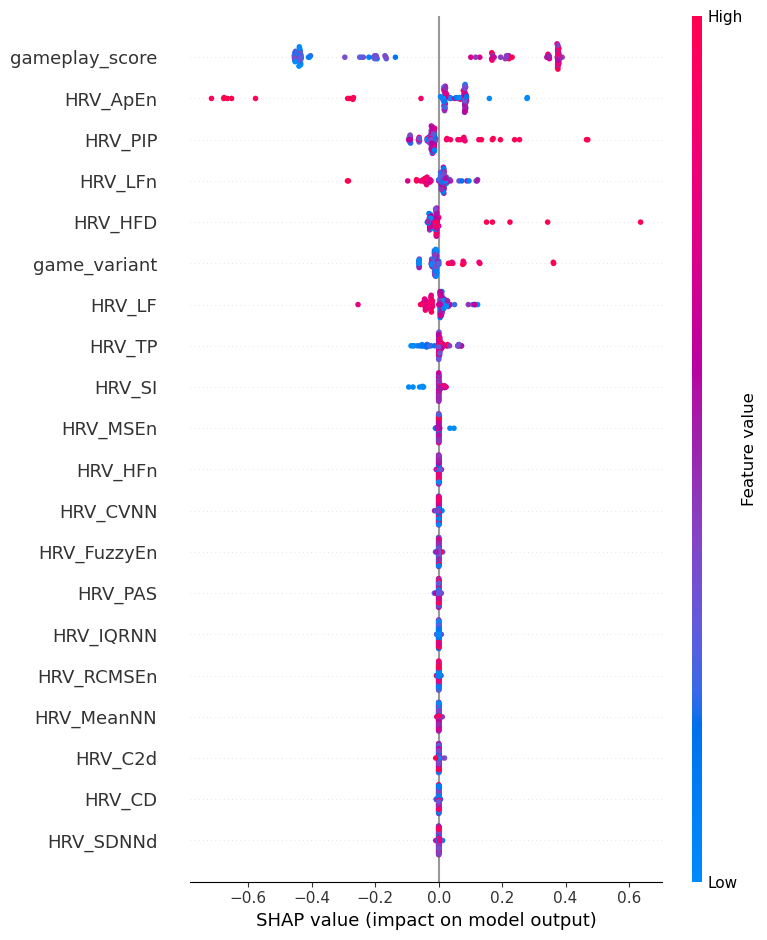

In [28]:
shap.summary_plot(ada_physio_shap_values, features=background_physio, feature_names=feature_names_physio)

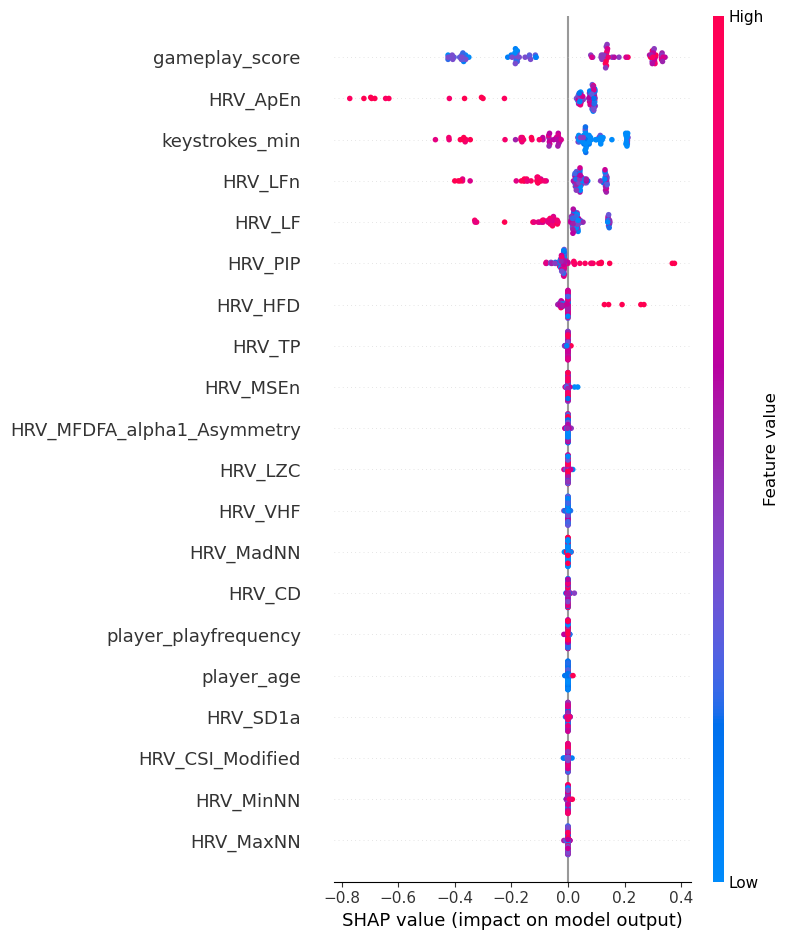

In [29]:
shap.summary_plot(ada_all_shap_values, features=background_all, feature_names=feature_names_all)

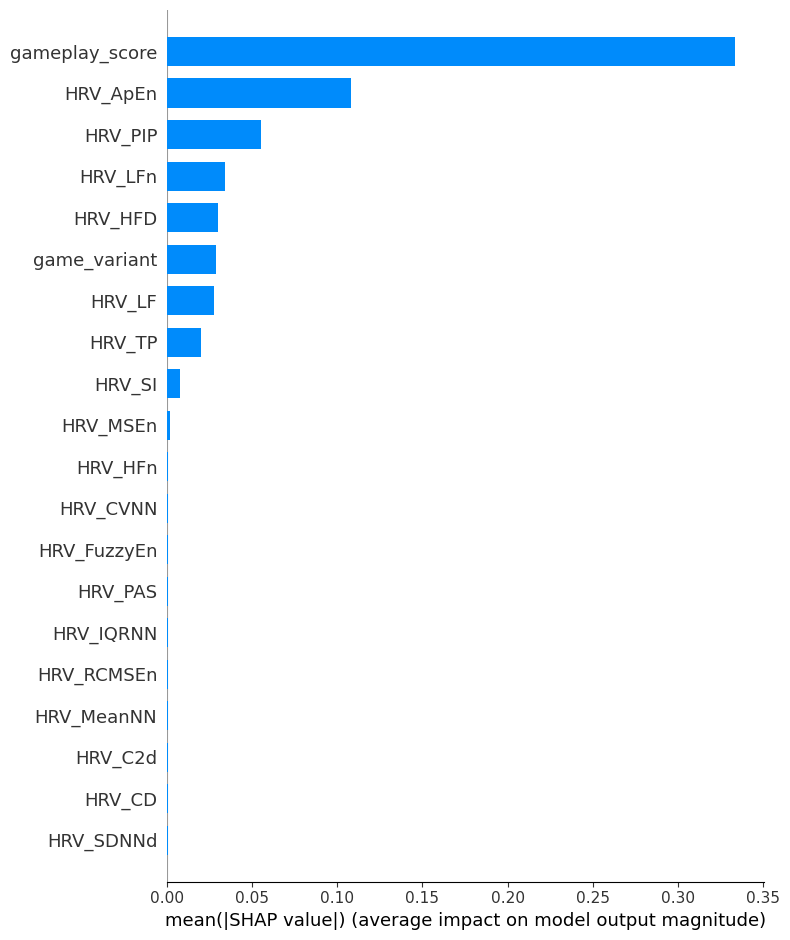

In [30]:
shap.summary_plot(ada_physio_shap_values, features=background_physio, feature_names=feature_names_physio, plot_type='bar')

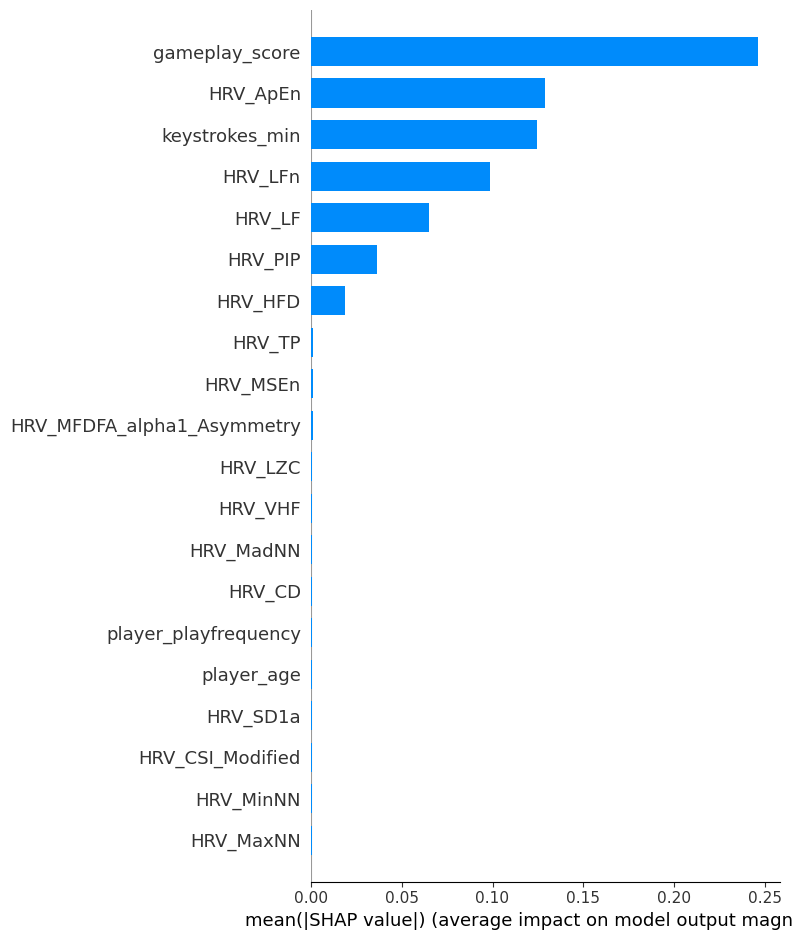

In [31]:
shap.summary_plot(ada_all_shap_values, features=background_all, feature_names=feature_names_all, plot_type='bar')

### LGBM Model Training
The following cells show the training and the result for the LGBM model. 

In [32]:
params_lgbm = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

#### LGBM model training with X_physio with predicting 'relaxtion' and 'fun' effects

In [33]:
lgbm_physio_relax, predictions_physio_lgbm_relax, labels_physio_lgbm_relax = training_model(X_physio, Y_relax, Z, params_lgbm, model='lgbm')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 46.95it/s]


In [34]:
accuracy_physio_lgbm_relax = np.mean(np.concatenate(predictions_physio_lgbm_relax) == np.concatenate(labels_physio_lgbm_relax))
print(accuracy_physio_lgbm_relax)

0.6840277777777778


In [35]:
lgbm_physio_fun, predictions_physio_lgbm_fun, labels_physio_lgbm_fun = training_model(X_physio, Y_fun, Z, params_lgbm, model='lgbm')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 59.19it/s]


In [36]:
accuracy_physio_lgbm_fun = np.mean(np.concatenate(predictions_physio_lgbm_fun) == np.concatenate(labels_physio_lgbm_fun))
print(accuracy_physio_lgbm_fun)

0.6597222222222222


#### LGBM model training with X_all with predicting 'relaxtion' and 'fun' effects

In [37]:
lgbm_all_relax, predictions_all_lgbm_relax, labels_all_lgbm_relax = training_model(X_all, Y_relax, Z, params_lgbm, model='lgbm')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 53.98it/s]


In [38]:
accuracy_all_lgbm_relax = np.mean(np.concatenate(predictions_all_lgbm_relax) == np.concatenate(labels_all_lgbm_relax))
print(accuracy_all_lgbm_relax)

0.6493055555555556


In [39]:
lgbm_all_fun, predictions_all_lgbm_fun, labels_all_lgbm_fun = training_model(X_all, Y_fun, Z, params_lgbm, model='lgbm')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 59.68it/s]


In [40]:
accuracy_all_lgbm_fun = np.mean(np.concatenate(predictions_all_lgbm_fun) == np.concatenate(labels_all_lgbm_fun))
print(accuracy_all_lgbm_fun)

0.6527777777777778


From the training above we can see that 

### Explainable with LGBM for 'fun'

To explain the LightGradientBoostingMachine, we are using the `shap.TreeExplainer` to explain the model.

For explaining the LGBMClassifier, I had only chosen `fun` effect for explaining.

In [41]:
explain_lgbm_physio = shap.TreeExplainer(lgbm_physio_fun, data=X_physio)
explain_lgbm_all = shap.TreeExplainer(lgbm_all_fun, data=X_all)

lgbm_physio_shap_values = explain_lgbm_physio.shap_values(X_physio, Y_fun)
lgbm_all_shap_values = explain_lgbm_all.shap_values(X_all, Y_fun)

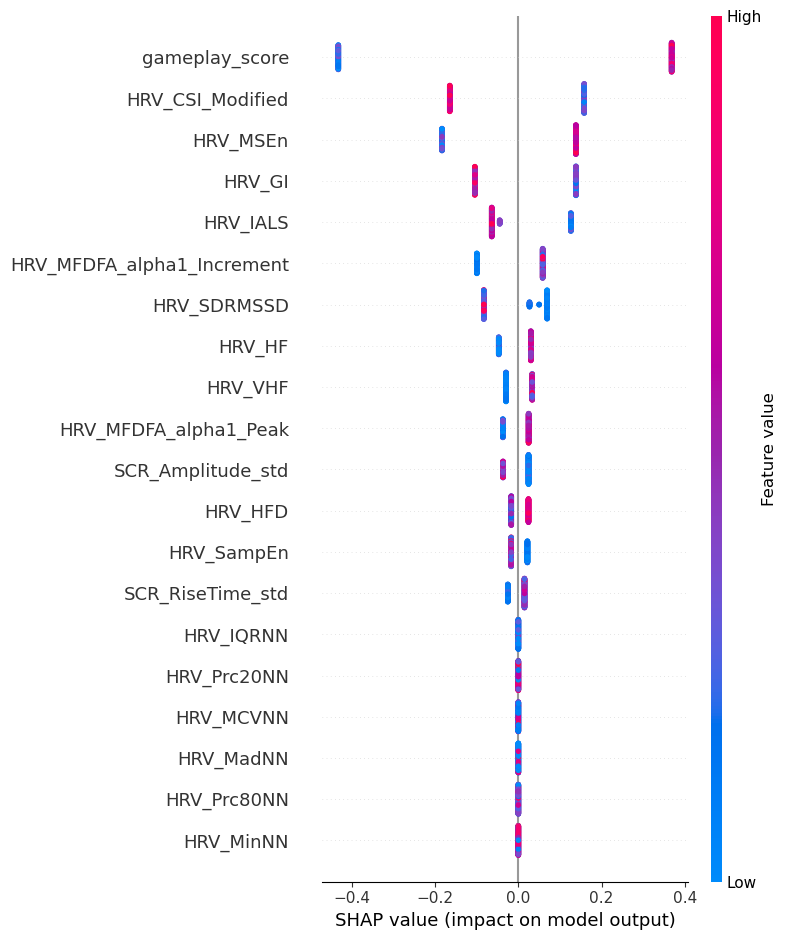

In [42]:
shap.summary_plot(lgbm_physio_shap_values, features=X_physio, feature_names=feature_names_physio)

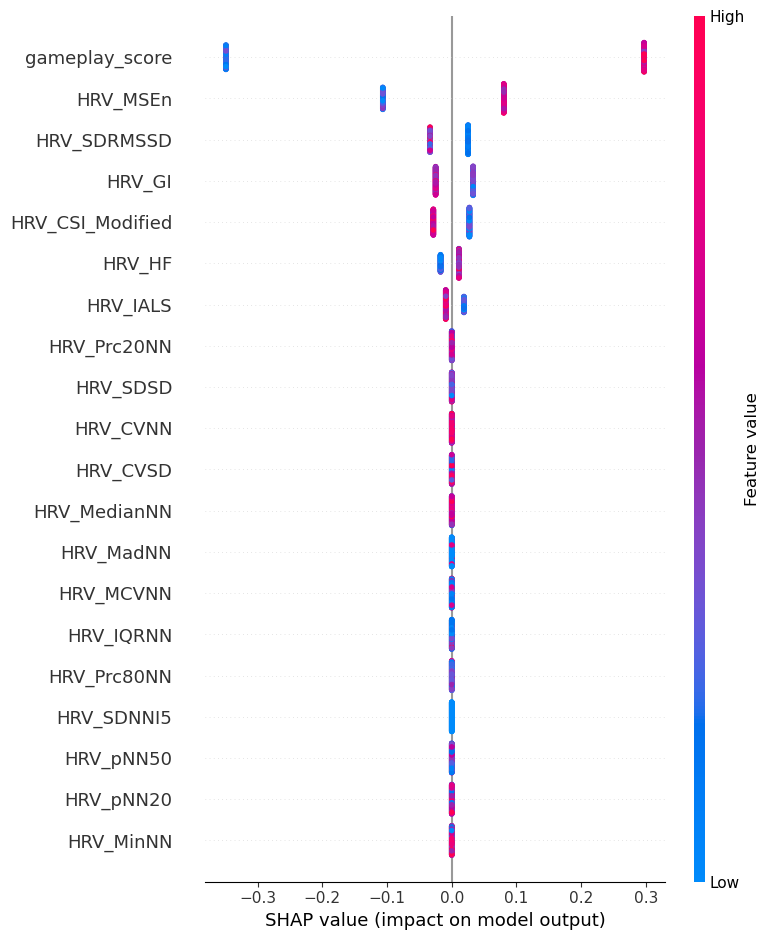

In [43]:
shap.summary_plot(lgbm_all_shap_values, features=X_all, feature_names=feature_names_all)

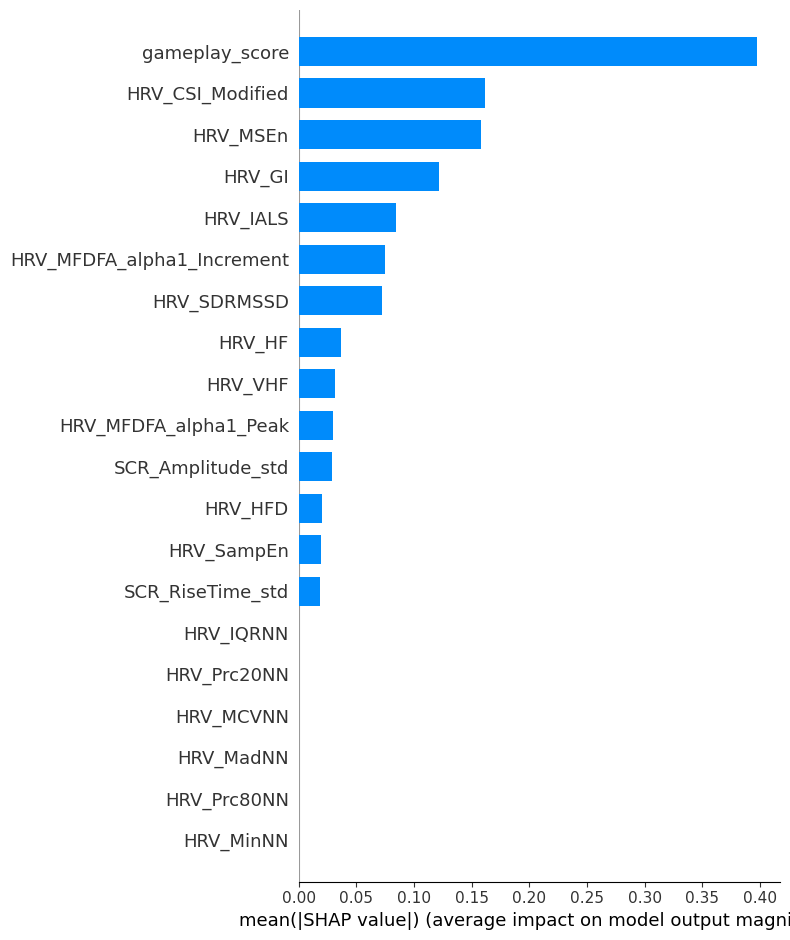

In [44]:
shap.summary_plot(lgbm_physio_shap_values, features=X_physio, feature_names=feature_names_physio, plot_type='bar')

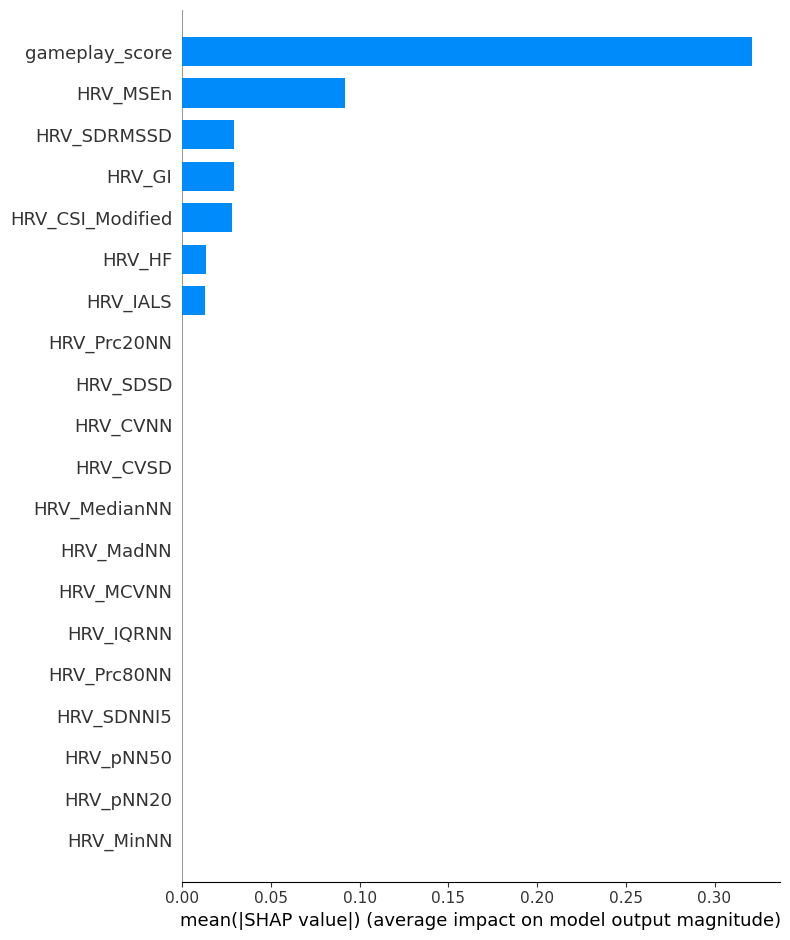

In [45]:
shap.summary_plot(lgbm_all_shap_values, features=X_all, feature_names=feature_names_all, plot_type='bar')